In [ ]:
from __future__ import print_function
import keras,sklearn
# suppress tensorflow compilation warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow.compat.v1 as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
seed=0
np.random.seed(seed) # fix random seed
tf.compat.v1.set_random_seed(seed)
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models, regularizers
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from urllib.request import urlopen 
import requests
import io
import time

# Grid search for best data augmentation for the preprocessing of Warshenstein's training data
Performed tested a number of different styles of data augmentation to determine what would give the best result. This is discussed further in the write up.

In [ ]:
all_cat_titles = ['airplane','monalisa','dragon','giraffe','axe','banana','eiffeltower','snail','windmill','snowman','schoolbus','smileyface','lollipop',]

img_rows, img_cols = 28, 28 

use_dataset_titles = ['X_use','Y_use']
ONLYFORFINALCOMPARATIVETEST_DATASETS_DONTYOUFUCKINGTOUCHTHESE = ['X_onlytest','Y_onlytest']
#DONT YOU DARE TOUCH THE ONLYTEST FILES.
#IF YOU ARE TRAINING A NEURAL NETWORK, TRAIN, VALIDATE, AND TEST FROM THE 'USE' FILES.

#load data
url_main = 'https://physics.bu.edu/~warsh/ML_QD/'
datalib={}

#loading samples
response = requests.get(url_main + use_dataset_titles[0] +'.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content), allow_pickle=False)
data = data.reshape(data.shape[0], img_rows*img_cols)
datalib[use_dataset_titles[0]] = data

response = requests.get(url_main + use_dataset_titles[1] +'.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content), allow_pickle=False)
datalib[use_dataset_titles[1]] = data

num_classes = int(max(datalib['Y_use'])+1)
cat_titles = all_cat_titles[:num_classes]
print('loaded:',cat_titles)

loaded: ['airplane', 'monalisa', 'dragon', 'giraffe', 'axe', 'banana', 'eiffeltower', 'snail', 'windmill', 'snowman']


an example of a data point with label windmill


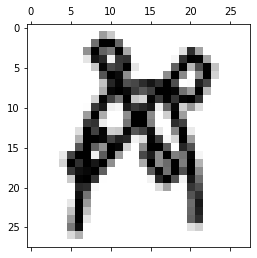

an example of a data point with label banana


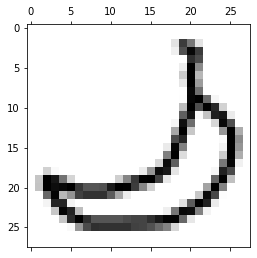

X_train shape: (53946, 28, 28, 1)
Y_train shape: (53946, 10)
X_valid shape: (13486, 28, 28, 1)
Y_valid shape: (13486, 10)
X_test shape: (202300, 28, 28, 1)
Y_test shape: (202300, 10)

53946 train samples
13486 validation samples
202300 test samples
269732 total


In [ ]:
Y_use = datalib['Y_use']
X_use = datalib['X_use']

#format, delegate, and scale data
ratio_use=.20
#use small portion, randomized already:
numosamps = len(Y_use)*ratio_use #number of samples used for train, validation, and testsets
test_size=.75 #20% test
tr2valr=.8 #64% train, 16% validation
num_classes=int(max(Y_use)+1)

#scramble and split!
X_tr, X_test, Y_tr, Y_test = train_test_split(X_use, Y_use, test_size=test_size, train_size=1.0-test_size)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_tr,Y_tr,train_size=tr2valr,test_size=1-tr2valr)

#how much we usin'
X_train = X_train[0:int(numosamps*(1.0-test_size)*tr2valr)]
Y_train = Y_train[0:int(numosamps*(1.0-test_size)*tr2valr)]
X_valid = X_valid[0:int(numosamps*(1.0-test_size)*(1.0-tr2valr))]
Y_valid = Y_valid[0:int(numosamps*(1.0-test_size)*(1.0-tr2valr))]
X_test = X_test[0:int(numosamps*test_size)]
Y_test = Y_test[0:int(numosamps*test_size)]

#reshape into 2D
X_train = X_train.reshape(X_train.shape[0],img_rows,img_cols)
X_valid = X_valid.reshape(X_valid.shape[0],img_rows,img_cols)
X_test = X_test.reshape(X_test.shape[0],img_rows,img_cols)

#yeah okay some floats
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

#scale onto the fun zer-O to O-ne inverval
X_train /= 255
X_valid /= 255
X_test /= 255

X_train_IS = X_train
X_valid_IS = X_valid
X_test_IS = X_test

def channel_and_size(X_t,pv,nchan):
    pad=int((pv-28)/2)
    npad = ((0, 0), (pad, pad), (pad, pad))
    #pad to proper image size - alternatives could be resize up, but I chose just a pad
    X_t = np.pad(X_t, pad_width=npad, mode='constant', constant_values=0)
    #add channels
    X_t = np.stack((X_t,)*nchan, axis=-1)
    return X_t

#display some stuff
for i in range(2):
    print('an example of a data point with label', cat_titles[int(Y_train[i])])
    plt.matshow(X_train[i,:],cmap='binary')
    plt.show()

# converting the actual numbers to the the one-hot vectors
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
Y_valid = keras.utils.to_categorical(Y_valid, num_classes)

#reshape data, depending on Keras backend, final data formatting
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols,1)
    input_shape = (img_rows, img_cols, 1)

#more debugging shit
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_valid shape:', X_valid.shape)
print('Y_valid shape:', Y_valid.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

print(X_train.shape[0]+X_valid.shape[0]+X_test.shape[0], 'total')

In [ ]:
allmodels={}
allhistory={}
allscores={}

#all models evaluated over 10 epochs with batchsize of 256
batch=256
ep=10

In [ ]:
#data augments for search
dataaug_0_noflip = ImageDataGenerator(rotation_range=0,zoom_range = 0,width_shift_range=0,height_shift_range=0, horizontal_flip=False, vertical_flip=False) 

dataaug_0_flip = ImageDataGenerator(rotation_range=0,zoom_range = 0,width_shift_range=0,height_shift_range=0, horizontal_flip=True, vertical_flip=True) 

dataaug_4_noflip = ImageDataGenerator(rotation_range=4,zoom_range = 0.04,width_shift_range=0.04,height_shift_range=0.04, horizontal_flip=False, vertical_flip=False) 

dataaug_4_flip = ImageDataGenerator(rotation_range=4,zoom_range = 0.04,width_shift_range=0.04,height_shift_range=0.04, horizontal_flip=True, vertical_flip=True) 

dataaug_8_noflip = ImageDataGenerator(rotation_range=8,zoom_range = 0.08,width_shift_range=0.08,height_shift_range=0.08, horizontal_flip=False, vertical_flip=False) 

dataaug_8_flip = ImageDataGenerator(rotation_range=8,zoom_range = 0.08,width_shift_range=0.08,height_shift_range=0.08, horizontal_flip=True, vertical_flip=True) 

dataaug_12_noflip = ImageDataGenerator(rotation_range=12,zoom_range = 0.12,width_shift_range=0.12,height_shift_range=0.12, horizontal_flip=False, vertical_flip=False) 

dataaug_12_flip = ImageDataGenerator(rotation_range=12,zoom_range = 0.12,width_shift_range=0.12,height_shift_range=0.12, horizontal_flip=True, vertical_flip=True) 

dataaug_16_noflip = ImageDataGenerator(rotation_range=16,zoom_range = 0.16,width_shift_range=0.16,height_shift_range=0.16, horizontal_flip=False, vertical_flip=False) 

dataaug_16_flip = ImageDataGenerator(rotation_range=16,zoom_range = 0.16,width_shift_range=0.16,height_shift_range=0.16, horizontal_flip=True, vertical_flip=True) 

In [ ]:
def create_CNN(el1,el2,opti,lays,nm):
    model = Sequential(name=nm)
    model.add(Conv2D(lays, kernel_size=(3, 3), activation='relu', input_shape=input_shape,
                     padding='same', kernel_regularizer=regularizers.l1_l2(l1=el1, l2=el2)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=lays*2, kernel_size = (3,3), activation="relu", 
                     padding='same', kernel_regularizer=regularizers.l1_l2(l1=el1*2, l2=el2*2)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())  
    model.add(Conv2D(filters=lays*2*2, kernel_size = (3,3), activation="relu", 
                     padding='same', kernel_regularizer=regularizers.l1_l2(l1=el1*4, l2=el2*4)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(lays*2*2*2,activation="relu"))
    model.add(Dense(num_classes,activation="softmax"))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opti,
                  metrics=['accuracy'])
    
    #lil something special to show us our architecture traits
    model.summary()
    return model

In [ ]:
lays=64
#found through gridsearch:
el1=0#.00008 
el2=0#.000008
#for gaussian layers:
noise=0 #well I found adding noise to this actually doesn't help.
opti='Adam' #gave best results of all optimizers attempted, next best was Adamax.

In [ ]:
name='gosh_0_noflip1'
train_gen = dataaug_0_noflip.flow(X_train, Y_train, batch_size=batch)
test_gen = dataaug_0_noflip.flow(X_test, Y_test, batch_size=batch)
valid_gen = dataaug_0_noflip.flow(X_valid, Y_valid, batch_size=batch)

allmodels[name] = create_CNN(el1,el2,opti,lays,noise)

allhistory[name] = allmodels[name].fit(train_gen, batch_size=batch,epochs=ep,verbose=1,validation_data=(valid_gen))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test,Y_test, verbose=1)
print(name + ' acc: %.2f'%allscores[name][1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 256)        

In [ ]:
name='gosh_0_flip1'
train_gen = dataaug_0_flip.flow(X_train, Y_train, batch_size=batch)
test_gen = dataaug_0_flip.flow(X_test, Y_test, batch_size=batch)
valid_gen = dataaug_0_flip.flow(X_valid, Y_valid, batch_size=batch)

allmodels[name] = create_CNN(el1,el2,opti,lays,noise)

allhistory[name] = allmodels[name].fit(train_gen, batch_size=batch,epochs=ep,verbose=1,validation_data=(valid_gen))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test,Y_test, verbose=1)
print(name + ' acc: %.2f'%allscores[name][1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 256)        

In [ ]:
name='gosh_4_noflip1'
train_gen = dataaug_4_noflip.flow(X_train, Y_train, batch_size=batch)
test_gen = dataaug_4_noflip.flow(X_test, Y_test, batch_size=batch)
valid_gen = dataaug_4_noflip.flow(X_valid, Y_valid, batch_size=batch)

allmodels[name] = create_CNN(el1,el2,opti,lays,noise)

allhistory[name] = allmodels[name].fit(train_gen, batch_size=batch,epochs=ep,verbose=1,validation_data=(valid_gen))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test,Y_test, verbose=1)
print(name + ' acc: %.2f'%allscores[name][1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 256)        

In [ ]:
name='gosh_4_flip1'
train_gen = dataaug_4_flip.flow(X_train, Y_train, batch_size=batch)
test_gen = dataaug_4_flip.flow(X_test, Y_test, batch_size=batch)
valid_gen = dataaug_4_flip.flow(X_valid, Y_valid, batch_size=batch)

allmodels[name] = create_CNN(el1,el2,opti,lays,noise)

allhistory[name] = allmodels[name].fit(train_gen, batch_size=batch,epochs=ep,verbose=1,validation_data=(valid_gen))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test,Y_test, verbose=1)
print(name + ' acc: %.2f'%allscores[name][1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 256)        

In [ ]:
name='gosh_8_noflip1'
train_gen = dataaug_8_noflip.flow(X_train, Y_train, batch_size=batch)
test_gen = dataaug_8_noflip.flow(X_test, Y_test, batch_size=batch)
valid_gen = dataaug_8_noflip.flow(X_valid, Y_valid, batch_size=batch)

allmodels[name] = create_CNN(el1,el2,opti,lays,noise)

allhistory[name] = allmodels[name].fit(train_gen, batch_size=batch,epochs=ep,verbose=1,validation_data=(valid_gen))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test,Y_test, verbose=1)
print(name + ' acc: %.2f'%allscores[name][1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 256)        

In [ ]:
name='gosh_8_flip1'
train_gen = dataaug_8_flip.flow(X_train, Y_train, batch_size=batch)
test_gen = dataaug_8_flip.flow(X_test, Y_test, batch_size=batch)
valid_gen = dataaug_8_flip.flow(X_valid, Y_valid, batch_size=batch)

allmodels[name] = create_CNN(el1,el2,opti,lays,noise)

allhistory[name] = allmodels[name].fit(train_gen, batch_size=batch,epochs=ep,verbose=1,validation_data=(valid_gen))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test,Y_test, verbose=1)
print(name + ' acc: %.2f'%allscores[name][1])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 256)        

In [ ]:
name='gosh_12_noflip1'
train_gen = dataaug_12_noflip.flow(X_train, Y_train, batch_size=batch)
test_gen = dataaug_12_noflip.flow(X_test, Y_test, batch_size=batch)
valid_gen = dataaug_12_noflip.flow(X_valid, Y_valid, batch_size=batch)

allmodels[name] = create_CNN(el1,el2,opti,lays,noise)

allhistory[name] = allmodels[name].fit(train_gen, batch_size=batch,epochs=ep,verbose=1,validation_data=(valid_gen))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test,Y_test, verbose=1)
print(name + ' acc: %.2f'%allscores[name][1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 256)        

In [ ]:
name='gosh_12_flip1'
train_gen = dataaug_12_flip.flow(X_train, Y_train, batch_size=batch)
test_gen = dataaug_12_flip.flow(X_test, Y_test, batch_size=batch)
valid_gen = dataaug_12_flip.flow(X_valid, Y_valid, batch_size=batch)

allmodels[name] = create_CNN(el1,el2,opti,lays,noise)

allhistory[name] = allmodels[name].fit(train_gen, batch_size=batch,epochs=ep,verbose=1,validation_data=(valid_gen))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test,Y_test, verbose=1)
print(name + ' acc: %.2f'%allscores[name][1])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 256)        

In [ ]:
name='gosh_16_noflip1'
train_gen = dataaug_16_noflip.flow(X_train, Y_train, batch_size=batch)
test_gen = dataaug_16_noflip.flow(X_test, Y_test, batch_size=batch)
valid_gen = dataaug_16_noflip.flow(X_valid, Y_valid, batch_size=batch)

allmodels[name] = create_CNN(el1,el2,opti,lays,noise)

allhistory[name] = allmodels[name].fit(train_gen, batch_size=batch,epochs=ep,verbose=1,validation_data=(valid_gen))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test,Y_test, verbose=1)
print(name + ' acc: %.2f'%allscores[name][1])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 256)        

In [ ]:
name='gosh_16_flip1'
train_gen = dataaug_16_flip.flow(X_train, Y_train, batch_size=batch)
test_gen = dataaug_16_flip.flow(X_test, Y_test, batch_size=batch)
valid_gen = dataaug_16_flip.flow(X_valid, Y_valid, batch_size=batch)

allmodels[name] = create_CNN(el1,el2,opti,lays,noise)

allhistory[name] = allmodels[name].fit(train_gen, batch_size=batch,epochs=ep,verbose=1,validation_data=(valid_gen))

allmodels[name].save(name+'.h5')

np.save(name+'_hist_loss.npy',allhistory[name].history['loss'])
np.save(name+'_hist_val_loss.npy',allhistory[name].history['val_loss'])
np.save(name+'_hist_acc.npy',allhistory[name].history['accuracy'])
np.save(name+'_hist_val_acc.npy',allhistory[name].history['val_accuracy'])

allscores[name] = allmodels[name].evaluate(X_test,Y_test, verbose=1)
print(name + ' acc: %.2f'%allscores[name][1])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 7, 7, 256)       

In [ ]:
for key in allscores.keys():
  print(key, allscores[key])

gosh_0_flip1 [0.22322270274162292, 0.9426299929618835]
gosh_0_noflip1 [0.3908435106277466, 0.9335799813270569]
gosh_4_noflip1 [0.27500563859939575, 0.9407600164413452]
gosh_4_flip1 [0.21606098115444183, 0.9425299763679504]
gosh_8_noflip1 [0.22192451357841492, 0.9444500207901001]
gosh_8_flip1 [0.2127154916524887, 0.9396100044250488]
gosh_12_noflip1 [0.2082834392786026, 0.9514300227165222]
gosh_12_flip1 [0.28100690245628357, 0.9290500283241272]
gosh_16_noflip1 [0.22161875665187836, 0.9415500164031982]
gosh_16_flip1 [0.3211497366428375, 0.9097300171852112]
